In [1]:
import collections
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

# ボックス＝ミュラー法
$(0, 1)$の一様分布から正規分布を生成する手法。$(0, 1)$の一様分布に従う独立確率変数$X, Y$があるとき
$$U=\sqrt{-2\log X}\cos 2\pi Y$$
$$V=\sqrt{-2\log X}\sin 2\pi Y$$
はそれぞれ正規分布に従う**独立な**確率変数である。これがボックス＝ミュラー法である。

以下のコードではボックス＝ミュラー法によって一様分布`np.random.uniform`から生成される乱数が実際に正規分布の理論値$\frac{1}{2\pi}e^{-\frac{x^2}{2}}$とよく一致することを確かめる。

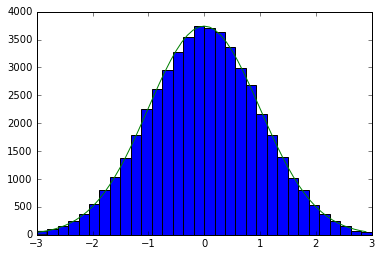

In [2]:
REPEAT = 50000
BINS = 32
RANGE = 3

x = np.random.uniform(size=[REPEAT])
y = np.random.uniform(size=[REPEAT])
plt.hist(np.sqrt(-2 * np.log(x)) * np.cos(2 * np.pi * y),
         bins=BINS, range=(-RANGE, RANGE))

logical_x = np.arange(-RANGE, RANGE, 0.1)
logical_y = np.exp(-np.power(logical_x, 2)/2)/np.sqrt(2*np.pi) * REPEAT / BINS * 2 * RANGE
plt.plot(logical_x, logical_y)

plt.show()

# 中心極限定理
ある平均$\mu$, 分散$\sigma^2$の母集団から独立にサンプルされた標本の値の和は標本数$n$が大きいとき、正規分布$N(n\mu,n\sigma^2)$に従う。これが中心極限定理である。中心極限定理は母集団分布がどのような分布族でも成立する。
以下のコードでは様々な分布に対して実際に和を計算し、正規分布でよく近似できることを確認する。

## 一様分布の場合
最小値$l$から最大値$h$までの一様分布は平均が$\frac{(h+l)}{2}$、分散は$\frac{(h-l)^2}{12}$であるから、$n$個の標本の和は中心極限定理より$N(n\frac{(h+l)}{2},n\frac{(h-l)^2}{12})$で近似できるはずである。$n=10$程度でもそれなりによく正規分布で近似できることが分かる。

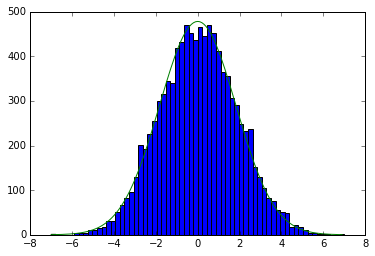

In [3]:
SAMPLE = 10
REPEAT = 10000

LOW = -1.0
HIGH = 1.0
RANGE = 7.
BINS=64

uni = np.random.uniform(low=LOW, high=HIGH, size=[SAMPLE, REPEAT])
plt.hist(np.sum(uni, axis=0),
         bins=BINS, range=(-RANGE, RANGE))

logical_var = SAMPLE * math.pow(HIGH - LOW, 2)/12.
logical_x = np.arange(-RANGE, RANGE, 0.1)
logical_y = np.exp(-np.power(logical_x, 2)/2/logical_var)/np.sqrt(2*np.pi*logical_var) * REPEAT / BINS * 2 * RANGE
plt.plot(logical_x, logical_y)

plt.show()

## 二項分布、ベルヌーイ分布の場合
確率$p$のベルヌーイの平均は$p$、分散は$p(1-p)$である。二項分布はベルヌーイ分布からの標本の和であるから、$n$が大きくなれば中心極限定理より正規分布で近似できる。なおベルヌーイ分布は不連続分布なので`plt.hist`ではなくて明示的にバケットを作ってグラフを描画している。$p=0.2$で分布が左右非対称なので$n=20$程度ではそこまで精度の高い近似にはなっていない。

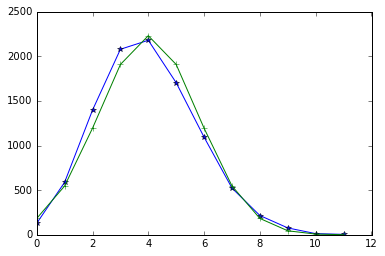

In [4]:
P = 0.2
SAMPLE = 20
REPEAT = 10 * 1000
RANGE = (0, 12)
BINS = 100

bernoulli = np.random.binomial(1, P, size=[SAMPLE, REPEAT])
binomial = np.sum(bernoulli, axis=0)

buckets = sorted(collections.Counter(binomial).items())
buckets_x, buckets_y = zip(*buckets)
plt.plot(buckets_x, buckets_y, '*-')

logical_var = SAMPLE * P * (1 - P)
logical_mean = SAMPLE * P
logical_x = np.arange(RANGE[0], RANGE[1], 1)
logical_y = np.exp(-np.power(logical_x - logical_mean, 2)/2/logical_var)/np.sqrt(2*np.pi*logical_var) * REPEAT
plt.plot(logical_x, logical_y, '+-')

plt.show()

# 偏分散
標本の分散を単純に計算したものは「偏分散」と呼ばれ、母集団分散が$\sigma^2$標本数$n$の場合、偏分散の期待値は$\frac{n-1}{n}\sigma^2$になる。
つまり偏分散は$\frac{n-1}{n}$だけ分散を過小評価してしまう。$\frac{n}{n-1}$をかけて補正したものを「不偏分散」という。

以下のコードでは分散$1$の正規分布から$n=10$サンプルした場合の「偏分散」の平均値を実際に計算し、$\frac{n-1}{n}=0.9$になることを確認する。

In [5]:
norm = np.random.normal(0, 1, size=[10, 10000])
vars = np.var(norm, axis=0)
np.mean(vars)

0.8944011263771614

# カイ二乗分布
正規分布の標本分散(偏分散)は自由度$n-1$のカイ二乗を$n$倍したものに従う。実際に`np.random.normal`を使って生成した正規分布に従う確率変数の分散が、理論値とよく一致することを確かめる。

理論値を求める場合は、まず分散`x`を標本数`SAMPLE`倍したものを`stats.chi2.pdf`に渡す。これは`x * SAMPLE`の確率密度であるから`x`の確率密度は`SAMPLE`倍する必要がある(注1)。その後、ヒストグラムの区間幅をかけて出現頻度の理論値を得る。

注1:
$y=kx$, $x,y$の確率密度を$f(x),g(y)$とすると$g(y)\Delta y=f(x)\Delta x$だから$f(x)=g(y)\frac{\Delta y}{\Delta x}=g(kx)g'(x)=kg(kx)$

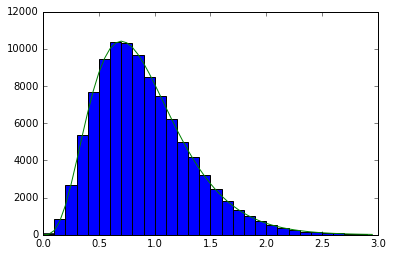

In [6]:
SAMPLE = 10
REPEAT = 100 * 1000
RANGE = (0, 3)
BINS = 30

# Histgram of 
norm = np.random.normal(0, 1, size=[SAMPLE, REPEAT])
vars = np.var(norm, axis=0)
plt.hist(vars, range=RANGE, bins=BINS)

# Theoretical value
x = np.arange(RANGE[0], RANGE[1], 0.05)
plt.plot(x, stats.chi2.pdf(x * SAMPLE, SAMPLE - 1) * SAMPLE * REPEAT * (RANGE[1] - RANGE[0]) / BINS)

plt.show()

# t分布
[スチューデントのt分布](https://ja.wikipedia.org/wiki/T%E5%88%86%E5%B8%83)。例え母集団分布が正規分布$N(\mu,\sigma^2)$であったとしても、母集団分散$\sigma^2$が未知であり、$\mu$に関して分析するにあたり$\sigma^2$を不偏分散$s^2$で代用してしまうと正規分布には従わなくなる。
ここでは実際に不偏分散で標準化した分布が正規分布の理論値(赤)ではなくt分布の理論値(緑)とよく一致することをシミューレーションして確かめる。
`SAMPLE`を大きくすれば$n$がある程度大きくなればt分布は正規分布とほぼ変わらなくなることも確認できる。

## 蛇足
これを実装する際に`np.sqrt(var)`とするところを誤って`var`としてしまっていて、理論値と比較するまで問題に気が付かなかった。機械学習とか統計処理とかのバグは見つけるのが非常に難しい。例えば機械学習はモデルが良くないからうまくいかないのか、モデルは正しいけれどコードにバグがあってうまくいかないのか判断が難しい。一般に、この手の問題はどうやって扱えばよいのだろう。

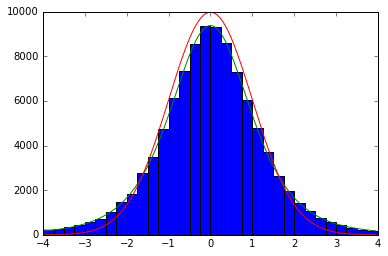

In [12]:
SAMPLE = 5
REPEAT = 100 * 1000
BINS = 32
RANGE = (-4, 4)

norm = np.random.normal(size=[SAMPLE, REPEAT])
mean = np.mean(norm, axis=0)
var = np.var(norm, axis=0) * SAMPLE/(SAMPLE-1)
normalized = mean / np.sqrt(var / SAMPLE)
plt.hist(normalized, range=RANGE, bins=BINS)

x = np.arange(RANGE[0], RANGE[1], 0.05)
plt.plot(x, stats.t.pdf(x, SAMPLE - 1) * REPEAT * (RANGE[1] - RANGE[0]) / BINS, 'green')
plt.plot(x, stats.norm.pdf(x) * REPEAT * (RANGE[1] - RANGE[0]) / BINS, 'red')
plt.show()

# 信頼区間
母集団分布が正規分布$N(\mu,\sigma^2)$の場合、$\mu$の信頼区間は($\sigma^2$が既知で信頼区間の計算に利用できる場合)
標本平均を$\bar X$とすると信頼区間は

$$\left(\bar X - \frac{Z_{\alpha/2}}{\sqrt n},\bar X + \frac{Z_{\alpha/2}}{\sqrt n}\right)$$

となる。

$\alpha=0.95$の場合、信頼区間が真の値を含む確率は95%である。
以下のコードでは実際に$N(0,1)$に対して平均$\bar X$から$\mu$の信頼区間を求める試行を繰り返し、信頼区間が真の値($\mu=0$)を含む確率が95%に非常に近くなることを確認する。

真の値$\mu=0$は未知ではあるが決まっているものであり、信頼区間が標本を選ぶという確率的行為によって変動する確率変数である点に注意したい。95%信頼区間というのは、信頼区間が真の値を含むような標本を選ぶ確率が95%なのであって、ある信頼区間が1つ与えられたときに真の値$\mu=0$が95%の確率で信頼区間の中に含まれるわけではない。真の値は決まっているのだからある信頼区間が与えられた場合、真の値が入る確率は0%か100%である。
仮説検定や信頼区間は真の値の確率分布を求める手法ではありません。

- [scipy.stats.norm](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.norm.html)

In [9]:
SAMPLE = 10
REPEAT = 100 * 1000
ALPHA = 0.95

norm = np.random.normal(size=[SAMPLE, REPEAT])
mean = np.mean(norm, axis=0)

ci_low = mean - stats.norm.interval(ALPHA)[1]/math.sqrt(SAMPLE)
ci_high = mean + stats.norm.interval(ALPHA)[1]/math.sqrt(SAMPLE)

inside_ci = np.logical_and(ci_low < 0, ci_high > 0)
np.count_nonzero(inside_ci)
print '%0.3f%%' % (100. * np.count_nonzero(inside_ci) / len(inside_ci))

95.045%


## 分散が未知の場合の正規分布の信頼区間
母集団分布が正規分布ではあるが分散が不明である場合、不偏分散$s^2$を真の分散$\sigma^2$の代わりに利用する。ただし不偏分散$s^2$を使って標準化した$\frac{\bar X-\mu}{s\sqrt{n}}$は正規分布$N(0,1)$には従いません。
$\frac{\bar X-\mu}{s\sqrt{n}}$は自由度$n-1$のt分布に従います。
そのため分散が未知の場合は、正規分布ではなくてt分布を使って信頼区間を求めないと間違った信頼区間を求めてしまうことになるので注意が必要です。

### 間違えて正規分布を使った場合
まずは誤って正規分布を利用して信頼区間を求めると、信頼区間が真の値を含む確率が期待通りでなくなってしまうことを実際に確かめてみます。

$$\left(\bar X - s\frac{Z_\alpha}{\sqrt n}, \bar X + s\frac{Z_\alpha}{\sqrt n}\right)$$

下のコードでは本来95%になるべき信頼区間が真の値を含む確率がおおよそ92%程度になってしまっていることが確認できます。標本数$n$が大きくなればt分布と正規分布の差がほとんどなくなるので、`SAMPLE`が大きければこの間違いによる影響は小さいこともわかります。

In [10]:
SAMPLE = 10
REPEAT = 100 * 1000
ALPHA = 0.95

norm = np.random.normal(size=[SAMPLE, REPEAT])
mean = np.mean(norm, axis=0)
var = np.var(norm, axis=0, ddof=1)
std = np.sqrt(var)
# print np.mean(var)

ci_low = mean - stats.norm.interval(ALPHA)[1]/math.sqrt(SAMPLE) * std
ci_high = mean + stats.norm.interval(ALPHA)[1]/math.sqrt(SAMPLE) * std

inside_ci = np.logical_and(ci_low < 0, ci_high > 0)
np.count_nonzero(inside_ci)
print '%0.3f%%' % (100. * np.count_nonzero(inside_ci) / len(inside_ci))

91.746%


### t分布を利用して正しく信頼区間を求めた場合
t分布を使って正しく信頼区間を求めれば、分散が未知の場合でも信頼区間が真の値を含む確率が95%になることが確認できます。
$$\left(\bar X-s\frac{t_\alpha}{\sqrt n},\bar X+s\frac{t_\alpha}{\sqrt n}\right)$$

References:
- [scipy.stats.t](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.t.html)
- [ddof argument of numpy.var](http://docs.scipy.org/doc/numpy/reference/generated/numpy.var.html)

In [11]:
SAMPLE = 10
REPEAT = 100 * 1000
ALPHA = 0.95

norm = np.random.normal(size=[SAMPLE, REPEAT])
mean = np.mean(norm, axis=0)
var = np.var(norm, axis=0, ddof=1)
std = np.sqrt(var)

ci_low = mean - stats.t.interval(ALPHA, SAMPLE - 1)[1]/math.sqrt(SAMPLE) * std
ci_high = mean + stats.t.interval(ALPHA, SAMPLE - 1)[1]/math.sqrt(SAMPLE) * std

inside_ci = np.logical_and(ci_low < 0, ci_high > 0)
np.count_nonzero(inside_ci)
print '%0.3f%%' % (100. * np.count_nonzero(inside_ci) / len(inside_ci))

95.011%
